In [17]:
import numpy as np
import pandas as pd
import folium
import shapely
import geopandas as gpd
import networkx as nx
import osmnx as ox
from pyproj import Geod

ox.settings.log_console = True
data_folder = "../data/"
geod = Geod(ellps="WGS84")

Utilities

In [18]:
def add_edge_linearity(G: nx.MultiDiGraph) -> nx.MultiDiGraph:
    """
    Add edge linearity to the graph
    """
    for u, v, k, data in G.edges(keys=True, data=True):
        greatc_old = ox.distance.great_circle_vec(G.nodes[u]["y"], G.nodes[u]["x"], G.nodes[v]["y"], G.nodes[v]["x"])

        if "geometry" not in data:
            print("geometry not in data", u, v)

        assert "geometry" in data
        
        start_x, start_y = data["geometry"].coords[0]
        end_x, end_y = data["geometry"].coords[-1]

        assert abs(start_x - G.nodes[u]["x"]) < 0.001
        assert abs(start_y - G.nodes[u]["y"]) < 0.001
        assert abs(end_x - G.nodes[v]["x"]) < 0.001
        assert abs(end_y - G.nodes[v]["y"]) < 0.001

        greatc_dist = ox.distance.great_circle_vec(start_y, start_x, end_y, end_x) 

        if abs(greatc_dist - greatc_old) > 1:
            print("len", data["length"])
            print("greatc", greatc_dist)
            print("greatc wrong", greatc_old)
            print("u:", G.nodes[u], "v:", G.nodes[v])
            print("start", (start_x, start_y), "end", (end_x, end_y))
            print()

        length = geod.geometry_length(data["geometry"])
        assert abs(length - data["length"]) < 0.001

        data["linearity"] = greatc_dist / length
    return G


def marker_from_row(row: pd.Series, m: folium.Map, icon: str = "info-sign", color: str = "blue"):
    """
    row: Series representing the POI to plot
    m: folium map object
    icon: icon name
    color: marker color
    """
    long, lat = row.geometry.x, row.geometry.y
    folium.Marker(
        location=[lat, long],
        popup=row.to_string(),
        icon=folium.Icon(icon=icon),
        color=color
    ).add_to(m)

Load platoon gps track in a geodataframe

In [19]:
df = pd.read_csv(f"{data_folder}platoon_route.csv", sep=r"\+ACI-,\+ACI-", names=["lat", "lng"], engine="python")
df = df.drop(df.index[0])

# remove prefix from lat column
df["lat"] = df["lat"].str.replace("+ACI-", "", regex=False).str.replace(",", ".").astype(float)
# remove suffix from lng column
df["lng"] = df["lng"].str.replace("+ACI-", "", regex=False).str.replace(",", ".").astype(float)

points = gpd.points_from_xy(df.lng, df.lat)
gdf = gpd.GeoDataFrame(df, geometry=points, crs="EPSG:4326")

In [4]:
# project the gdf to EPSG:3857
gdf_proj = gdf.to_crs("EPSG:3857")

# get the bounding box of the projected gdf
bbox_proj = gdf_proj.total_bounds

# enlarge bbox_proj by 500 meters
bbox_proj = [bbox_proj[0] - 500, bbox_proj[1] - 500, bbox_proj[2] + 500, bbox_proj[3] + 500]

# bbox_proj to polygon
bbox_proj_geom = gpd.GeoSeries([shapely.geometry.box(*bbox_proj)], crs="EPSG:3857").geometry
bbox_poly = bbox_proj_geom.to_crs("EPSG:4326").geometry.unary_union

# create a graph from the bounding box
G = ox.graph_from_polygon(bbox_poly, network_type="drive")

# only simplified edges have the geometry attribute
# see https://stackoverflow.com/questions/64333794/osmnx-graph-from-point-and-geometry-information
nodes, edges = ox.graph_to_gdfs(G, fill_edge_geometry=True)
G = ox.graph_from_gdfs(nodes, edges)

G = ox.add_edge_bearings(G)
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

G = add_edge_linearity(G)
ox.save_graphml(G, f"{data_folder}graph.graphml")

traffic_lights = ox.geometries_from_polygon(bbox_poly, tags={'highway': 'traffic_signals'})
traffic_lights.to_file(f"{data_folder}traffic-lights.geojson")

In [20]:
G = ox.load_graphml(f"{data_folder}graph.graphml")
traffic_lights = gpd.read_file(f"{data_folder}traffic-lights.geojson")

In [21]:
nodes['df_index'] = nodes.index
edges['df_index'] = edges.index

m = edges.explore(tiles="CartoDB positron", popup=True, tooltip=False, color="black")
m = nodes.explore(m=m, popup=True, tooltip=False, color="black")
m

In [22]:
# Origin and destination nodes
orig_node = 87985973
dest_node = 201850457
# Cost to minimize (pick from edge attributes)
weight = 'length'

path = ox.shortest_path(G, orig_node, dest_node, weight, cpus=None)
marker_from_row(row=nodes.loc[orig_node], m=m, icon="flag", color="green")
marker_from_row(row=nodes.loc[dest_node], m=m, icon="screenshot", color="red")

node_pairs = zip(path[:-1], path[1:])
uvk = ((u, v, min(G[u][v].items(), key=lambda k: k[1]["length"])[0]) for u, v in node_pairs)
path_edges = ox.graph_to_gdfs(G.subgraph(path), nodes=False).loc[uvk]

path_edges["df_index"] = path_edges.index
m = path_edges.explore(m=m, popup=True, tooltip=False, color="DeepSkyBlue")
m

In [33]:
edges = ox.graph_to_gdfs(G, nodes=False)
edges['line']

osmid  oneway lanes  \
u          v          key                                                     
122349     21765918   0                              22672043    True     3   
           540212344  0                             164239562    True     2   
21765918   243175300  0                             205199627    True     3   
           243180247  0                               8060333    True     2   
540212344  21765918   0                              43118565    True     1   
...                                                       ...     ...   ...   
8541234721 8541234717 0                             919748507    True     2   
8827815113 2589886679 0                [660916747, 252993341]    True     1   
           36685306   0                             941838119    True     2   
8832485699 8832485672 0                             954306005    True   NaN   
8856305395 22120139   0    [957081048, 957081033, 1068722004]    True     2   

                           ref                                          name  \
u          v          key                                                      
122349     21765918   0    B 4                          Ludwig-Erhard-Straße   
           540212344  0    NaN                          Ludwig-Erhard-Straße   
21765918   243175300  0    B 4                          Ludwig-Erhard-Straße   
           243180247  0    NaN                                  Rödingsmarkt   
540212344  21765918   0    NaN                                  Rödingsmarkt   
...                        ...                                           ...   
8541234721 8541234717 0    NaN                               Altonaer Straße   
8827815113 2589886679 0    NaN  [Axel-Springer-Platz, Kaiser-Wilhelm-Straße]   
           36685306   0    NaN                           Axel-Springer-Platz   
8832485699 8832485672 0    NaN                                    Alsterufer   
8856305395 22120139   0    NaN                                 Jungfernstieg   

                               highway maxspeed reversed   length  \
u          v          key                                           
122349     21765918   0        primary       50    False   73.932   
           540212344  0       tertiary       50    False   76.296   
21765918   243175300  0        primary       50    False   20.904   
           243180247  0      secondary       50    False   58.820   
540212344  21765918   0      secondary       50    False   12.212   
...                                ...      ...      ...      ...   
8541234721 8541234717 0      secondary       50    False   55.534   
8827815113 2589886679 0       tertiary       50    False  103.586   
           36685306   0       tertiary       50    False   74.695   
8832485699 8832485672 0    residential       30    False   21.480   
8856305395 22120139   0    residential       30    False  268.352   

                                                                    geometry  \
u          v          key                                                      
122349     21765918   0    LINESTRING (9.98526 53.54794, 9.98543 53.54787...   
           540212344  0    LINESTRING (9.98526 53.54794, 9.98549 53.54792...   
21765918   243175300  0      LINESTRING (9.98627 53.54766, 9.98657 53.54761)   
           243180247  0    LINESTRING (9.98627 53.54766, 9.98619 53.54757...   
540212344  21765918   0      LINESTRING (9.98636 53.54775, 9.98627 53.54766)   
...                                                                      ...   
8541234721 8541234717 0    LINESTRING (9.96498 53.56512, 9.96512 53.56516...   
8827815113 2589886679 0    LINESTRING (9.98567 53.55210, 9.98561 53.55214...   
           36685306   0    LINESTRING (9.98567 53.55210, 9.98564 53.55216...   
8832485699 8832485672 0    LINESTRING (9.99786 53.56307, 9.99784 53.56314...   
8856305395 22120139   0    LINESTRING (9.99383 53.55249, 9.99380 53.55251...   

                           bearing  speed_kph  t

c:\Users\alber\anaconda3\envs\platoon_routing_env\Lib\site-packages\osmnx\plot.py:680: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scalar_mapper = cm.ScalarMappable(normalizer, cm.get_cmap(cmap))


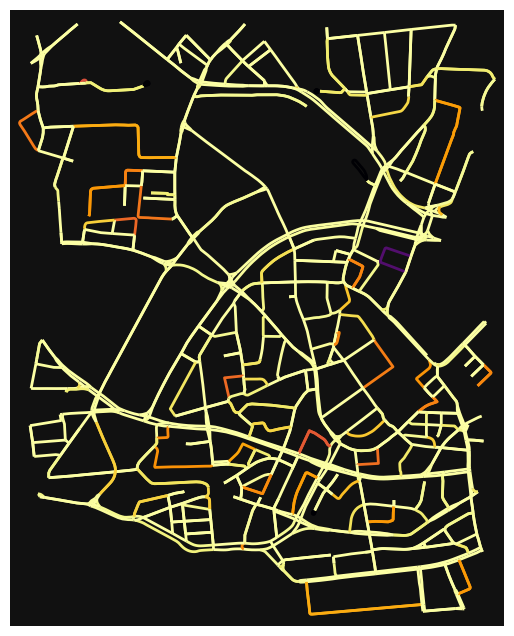

In [36]:
# cast edge linearity to float
edges["linearity"] = edges["linearity"].astype(float)
G = ox.graph_from_gdfs(nodes, edges)

ec = ox.plot.get_edge_colors_by_attr(G, "linearity", cmap="inferno")
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)


In [41]:
m = nodes.explore(tiles="CartoDB positron", popup=True, tooltip=False, color="black")
m = edges[edges.linearity < 0.95].explore(m=m, popup=True, tooltip=False, color="red")
edges[edges.linearity >= 0.95].explore(m=m, popup=True, tooltip=False, color="green")